# Проект: Прогнозирование заказов такси

## Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

## Техническое задание
1. **Предобработка данных**
    - Загрузить данные
    - Выполнить их ресемплирование по одному часу
    - Проанализировать данные
2. **Обучение моделей**
    - Обучить несколько моделей и выбрать из них лучшую
3. **Написать общий вывод по проделанной работе**

## Все необходимые загрузки и импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from time import time


## Все функции используемые в проекте

In [2]:
def make_rolling_mean_std(df: pd.DataFrame,
                          num_col: str,
                          resample_size: str,
                          rolling_mean_size=10,
                          rolling_std_size=10,
                         ) -> None:
    
    '''
    Функция принимает в качестве параметров датафрейм по которому будет проводиться
    ресемплирование. Название столбца в котором храниться информация по которой нужно строить
    скользящее среднее и дисперсию. Масштаб ресемплирования и масштабы для вывода скользящего
    среднего и дисперсии, по дефолту они равны 10
    '''
    fig, ax = plt.subplots(1, 1, figsize=(18, 6))
    df_resample = df.resample(resample_size).sum()
    df_resample['rolling_mean'] = df_resample[num_col].rolling(rolling_mean_size).mean() 
    df_resample['std'] = df_resample[num_col].rolling(rolling_std_size).std()
    df_resample.plot(ax=ax)
    plt.show()

In [3]:
def plot_preds_true(y_true: pd.Series,
                    y_pred: pd.DataFrame,
                    col_name='предсказание',
                    model_name='модели'
                   ) -> None:
    
    '''
    Функция принимает на вход датафрейм с истинными значениями, с предсказаниями и строит
    визуализацию предсказаний.
    '''
    
    df_to_plot = y_true.reset_index()
    df_to_plot[col_name] = y_pred
    df_to_plot.set_index('datetime', inplace=True)
    plt.figure(figsize=(18, 5))
    plt.subplot(111)
    df_to_plot.plot(ax=plt.gca())
    plt.title(f'Визуализация предсказаний {model_name} на тесте', fontsize=20, fontweight='bold')
    plt.show()

In [4]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

## Загрузка данных

In [5]:
try:
    df = pd.read_csv('datasets/taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


На первый взгляд с данными все в порядке, можно переходить к их изучение и предобработке

## Изучение и предобработка данных.

В превую очередь проверим типы данных

In [6]:
df.dtypes

datetime      object
num_orders     int64
dtype: object

Необходимо перевести дату в тип datetime

In [7]:
df['datetime'] = df['datetime'].astype('datetime64')
df.dtypes

datetime      datetime64[ns]
num_orders             int64
dtype: object

Рассмотрим какой временной промежуток нам дан 

In [8]:
print(f'Первая дата {df["datetime"].min()}')
print(f'Последняя дата {df["datetime"].max()}')

Первая дата 2018-03-01 00:00:00
Последняя дата 2018-08-31 23:50:00


Временные промежутки между записями 10 минут, попробуем вывести график в таком виде, а потом проведем реыемплирование. Но сначала сделаем дату индексом и отсортируем индексы на всякий случай

In [9]:
df.set_index('datetime', inplace=True)
df.head()
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [10]:
df.sort_index(inplace=True)

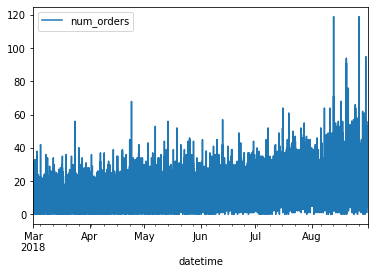

In [11]:
df.plot()
plt.show()

По такому семплу ничего не видно. Единственное, что можно сказать, что есть тренд на возрастание количества заказов в конце августа. Сделаем ресемплирование и рассмотрим ряд еще раз

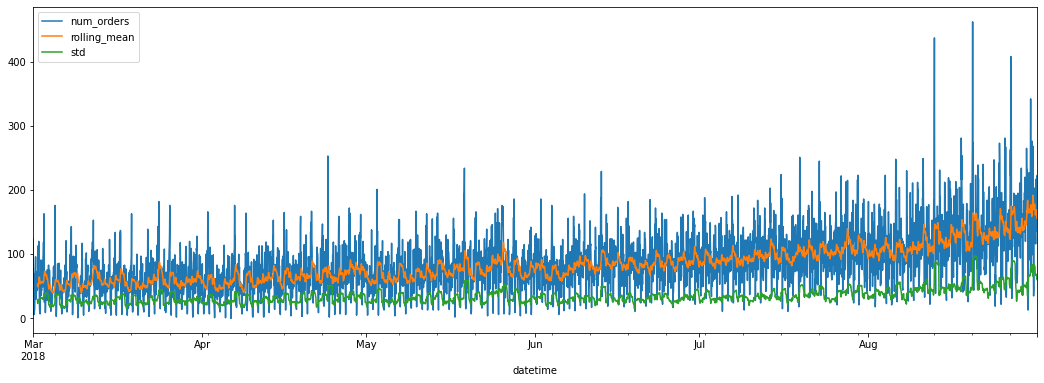

In [12]:
make_rolling_mean_std(df, 'num_orders', '1H', 20, 20)

По этим данным неудобно рассматривать значения, поэтму ресемплируем данные по одному дню и изучим раяд на полученных данных.

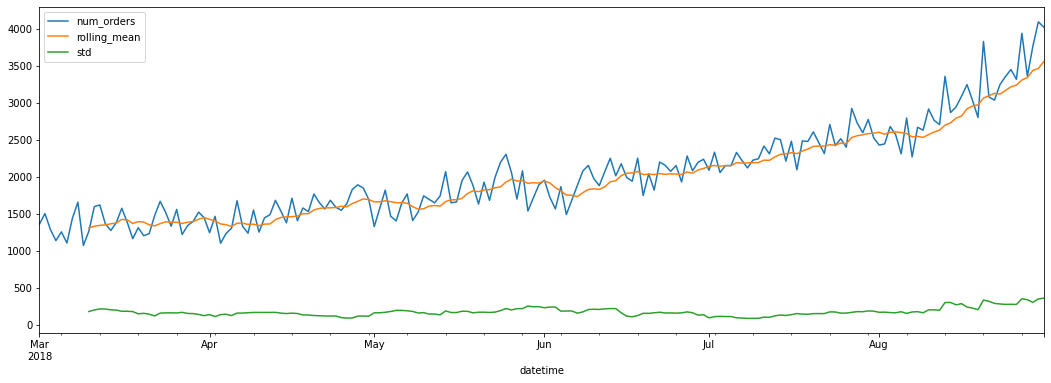

In [13]:
make_rolling_mean_std(df, 'num_orders', '1D')

Тут уже можно сказать, что ряд не стационарный, потому что его среднее значение изменятся. Изучим тренд, сезонность и остатки в этих редах. Перед этим ресемплируем ряд по одному часу.

In [14]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Для рассмотрения сезонности возьмем промежуток времени поменьше.

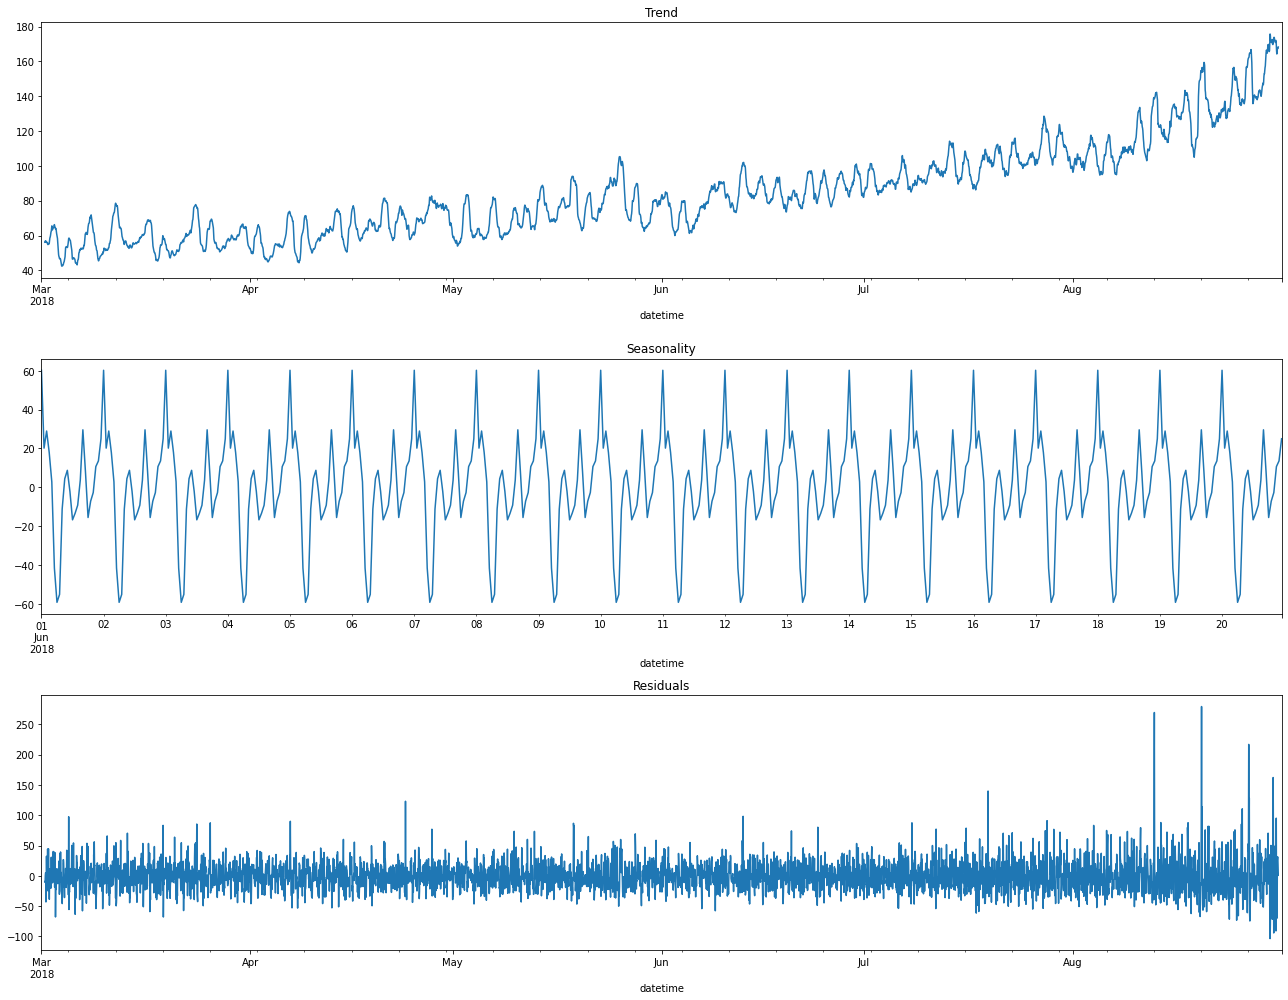

In [15]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(18, 14))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-06-20'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По грфикам видно, что тренд идет на повышение количества заказов. Сезонность говорит о том, что самое большое количество заказзов приходиься на конец дня, пик находиться около 23:00, самое маленькое количиство заказов приходится на ночь приблизительно 4-5 утра. В остатках видны выбросы, все пики приходятся на конец августа.

### Вывод по изучению и предобработке даных.
В ходе изучения было выявлено:
- Ряд вряд-ли является стационарным, так как его среднее значение изменяться
- Тренд идет на повышение количества заказов
- Сезонность говорит о том, что самое большое количество заказов приходиться на конец дня, а самое маленькое на ночь
- В остатках видны выбросы, все пики остатков приходятся на конец августа, там же заметно резкое возрастание количества заказов

## Обучение моделей


Сначала, для поверки моделей на адекватность сначала предскажем данные константой, потом предыдущим значением ряда. Но сначала нужно разделить данные на тренировочную и на тестовую выборку.

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=.1)
train.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Предсказание константой

В качетве константы будем использовать среднее значение

In [17]:
print(f'Медианное количество заказов за час {round(df["num_orders"].mean(), 2)}')

preds_median = np.ones(test.shape[0]) * df['num_orders'].mean()
rmse_median = round(mean_squared_error(test, preds_median, squared=False), 2)
print(f'Метрика RMSE предсказания константой равна {rmse_median}')

Медианное количество заказов за час 84.42
Метрика RMSE предсказания константой равна 80.42


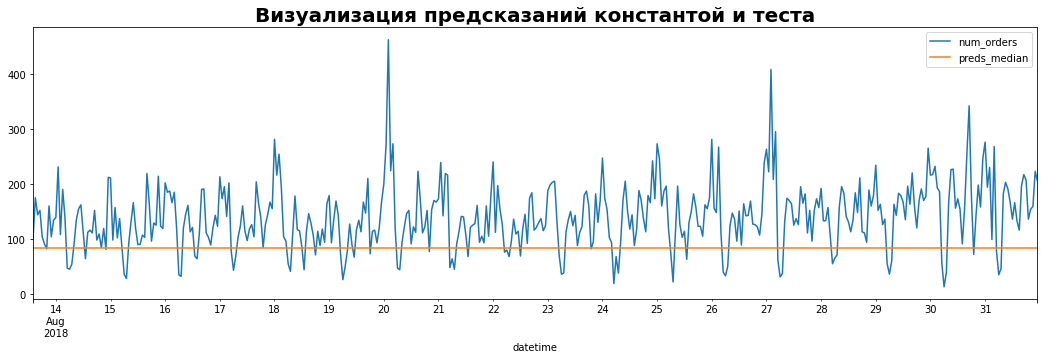

In [18]:
test['preds_median'] = preds_median
plt.figure(figsize=(18, 5))
plt.subplot(111)
test.plot(ax=plt.gca())
plt.title('Визуализация предсказаний константой и теста', fontsize=20, fontweight='bold')
plt.show()

### Предсказание предыдущим значением

In [19]:
preds_previous = test['num_orders'].shift(fill_value=train['num_orders'].iloc[train.shape[0]-1])
rmse_previous = round(mean_squared_error(test['num_orders'], preds_previous, squared=False), 2)
print(f'Метрика RMSE предсказания предыдущим значением {rmse_previous}')

Метрика RMSE предсказания предыдущим значением 58.86


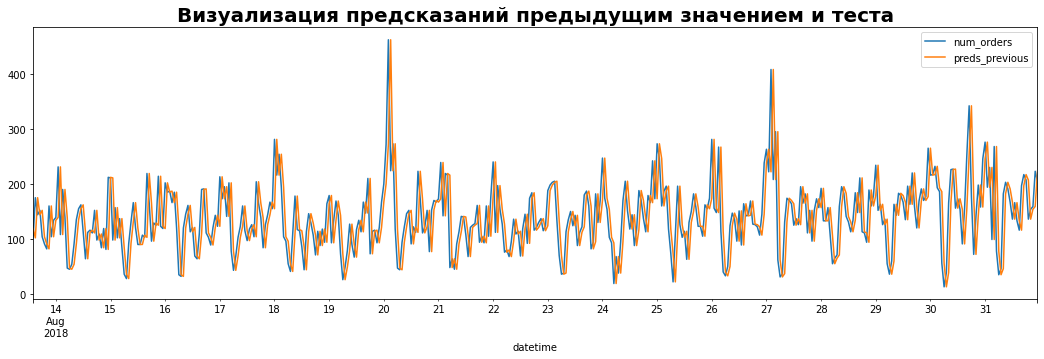

In [20]:
test = test.drop('preds_median', axis=1)
test['preds_previous'] = preds_previous
plt.figure(figsize=(18, 5))
plt.subplot(111)
test.plot(ax=plt.gca())
plt.title('Визуализация предсказаний предыдущим значением и теста', fontsize=20, fontweight='bold')
plt.show()

Это предсказание работает заметно точнее чем константное, теперь нужно создать дополнительные модели машинного обучения, но для этого сначала нужно создать дополнительные признаки. Удалим ненужные переменные.

In [21]:
del test, train, preds_median, preds_previous

### Создание дополнительных признаков и разделение данных

In [22]:
make_features(df, 20, 15)

In [23]:
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
train, test = train_test_split(df, shuffle=False, test_size=.1)

In [25]:
train.dropna(inplace=True)

In [26]:
train.tail(1)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 13:00:00,119,0,13,92.0,144.0,156.0,137.0,91.0,39.0,66.0,...,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,152.8


In [27]:
test.head(1)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,...,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,152.866667


Все разделилось правильно можно разбить выборки на целевые и на фичи и начинать обучать модели. 

In [28]:
X_train = train.drop('num_orders', axis=1)
X_test = test.drop('num_orders', axis=1)

y_train = train['num_orders']
y_test = test['num_orders']
X_train.head()

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 20:00:00,3,20,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,45.133333
2018-03-01 21:00:00,3,21,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,48.800000
2018-03-01 22:00:00,3,22,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,52.400000
2018-03-01 23:00:00,3,23,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,58.933333
2018-03-02 00:00:00,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,60.533333


### DecisionTreeRegressor, RandomForestRegression, LinearRegression

In [29]:
RANDOM_STATE = 42
base_model = Pipeline(
    [
        ('models', LinearRegression(n_jobs=-1))
    ]
)

param_grid = [
    {
        'models' :  [LinearRegression(n_jobs=-1)]
    },
    {
        'models' : [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth' : range(2, 10),
        'models__max_features' : range(2, 10),
        'models__min_samples_split' : range(2, 10),
        'models__min_samples_leaf' : range(1, 10),
        'models__max_features' : range(1, 10)
    },
    {
        'models' : [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators' : (30, 300, 5),
        'models__max_depth' : range(2, 10),
        'models__max_features' : range(2, 10),
        'models__min_samples_split' : range(2, 10),
        'models__min_samples_leaf' : range(1, 10),
        'models__max_features' : range(1, 10)
    }
]

In [30]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

rs = RandomizedSearchCV(
    base_model, 
    param_grid, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_iter=200,
    n_jobs=-1
)
rs.fit(X_train, y_train)


print(f'Метрика RMSE лучшей модели на кросс-валидации равна {round(-rs.best_score_, 2)}')
print('Лучшая модель и ее гиперпараметры: \n', rs.best_estimator_)

Метрика RMSE лучшей модели на кросс-валидации равна 26.73
Лучшая модель и ее гиперпараметры: 
 Pipeline(steps=[('models',
                 RandomForestRegressor(max_depth=9, max_features=9,
                                       min_samples_leaf=4, min_samples_split=5,
                                       n_estimators=30, random_state=42))])
Wall time: 1min 33s


Уже хороший результат, попробуем обучить еще одну модель градиентного бустинга, но сначала посмотрим лучшие пять моделей на этапе кросс-валидации

In [31]:
pd.set_option('display.max_colwidth', None)
models_info_df = (pd.DataFrame(rs.cv_results_)
  [['params', 'mean_test_score', 'rank_test_score', 'mean_fit_time', 'mean_score_time']]
  .sort_values(by='mean_test_score', ascending=False))
models_info_df['mean_test_score'] = -models_info_df['mean_test_score']
models_info_df.head()

,params,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
179,"{'models__n_estimators': 30, 'models__min_samples_split': 5, 'models__min_samples_leaf': 4, 'models__max_features': 9, 'models__max_depth': 9, 'models': RandomForestRegressor(random_state=42)}",26.733975,1,0.855357,0.010313
191,"{'models__n_estimators': 300, 'models__min_samples_split': 2, 'models__min_samples_leaf': 7, 'models__max_features': 9, 'models__max_depth': 9, 'models': RandomForestRegressor(random_state=42)}",26.833897,2,7.385248,0.049574
156,"{'models__n_estimators': 300, 'models__min_samples_split': 5, 'models__min_samples_leaf': 3, 'models__max_features': 7, 'models__max_depth': 9, 'models': RandomForestRegressor(random_state=42)}",26.851583,3,7.108844,0.057732
77,"{'models__n_estimators': 300, 'models__min_samples_split': 6, 'models__min_samples_leaf': 4, 'models__max_features': 8, 'models__max_depth': 8, 'models': RandomForestRegressor(random_state=42)}",27.155691,4,6.892721,0.054803
23,"{'models__n_estimators': 300, 'models__min_samples_split': 9, 'models__min_samples_leaf': 3, 'models__max_features': 8, 'models__max_depth': 8, 'models': RandomForestRegressor(random_state=42)}",27.160868,5,6.939774,0.053326


Первые пять позиций занимет модель RandomForestRegressor. Предсказания первых пяти моделей не сильно отличаются.

### LGBRegressor

In [32]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'num_leaves': [2, 5, 7, 12]
}

lgb_model = LGBMRegressor(random_state=RANDOM_STATE)

gs = GridSearchCV(lgb_model, param_grid, scoring='neg_root_mean_squared_error', cv=tscv)
gs.fit(X_train, y_train)

print(f'Метрика RMSE лучшей модели на кросс-валидации равна {round(-gs.best_score_, 2)}')
print('Лучшая модель и ее гиперпараметры: \n', gs.best_estimator_)

Метрика RMSE лучшей модели на кросс-валидации равна 25.19
Лучшая модель и ее гиперпараметры: 
 LGBMRegressor(n_estimators=300, num_leaves=7, random_state=42)


In [33]:
pd.set_option('display.max_colwidth', None)
boost_models_info_df = (pd.DataFrame(gs.cv_results_)
  [['params', 'mean_test_score', 'rank_test_score', 'mean_fit_time', 'mean_score_time']]
  .sort_values(by='mean_test_score', ascending=False))
boost_models_info_df['mean_test_score'] = -boost_models_info_df['mean_test_score']
boost_models_info_df.head()

,params,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
14,"{'n_estimators': 300, 'num_leaves': 7}",25.186743,1,0.109744,0.006107
10,"{'n_estimators': 200, 'num_leaves': 7}",25.194158,2,0.079128,0.005034
11,"{'n_estimators': 200, 'num_leaves': 12}",25.218118,3,0.114847,0.005854
15,"{'n_estimators': 300, 'num_leaves': 12}",25.276121,4,0.154047,0.006404
7,"{'n_estimators': 100, 'num_leaves': 12}",25.296173,5,0.065017,0.004645


## Анализ моделей

Еще раз рассмотрим таблицы с рещультатами работы моделей на кросс-валидации.

In [34]:
models_info_df.head()

,params,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
179,"{'models__n_estimators': 30, 'models__min_samples_split': 5, 'models__min_samples_leaf': 4, 'models__max_features': 9, 'models__max_depth': 9, 'models': RandomForestRegressor(random_state=42)}",26.733975,1,0.855357,0.010313
191,"{'models__n_estimators': 300, 'models__min_samples_split': 2, 'models__min_samples_leaf': 7, 'models__max_features': 9, 'models__max_depth': 9, 'models': RandomForestRegressor(random_state=42)}",26.833897,2,7.385248,0.049574
156,"{'models__n_estimators': 300, 'models__min_samples_split': 5, 'models__min_samples_leaf': 3, 'models__max_features': 7, 'models__max_depth': 9, 'models': RandomForestRegressor(random_state=42)}",26.851583,3,7.108844,0.057732
77,"{'models__n_estimators': 300, 'models__min_samples_split': 6, 'models__min_samples_leaf': 4, 'models__max_features': 8, 'models__max_depth': 8, 'models': RandomForestRegressor(random_state=42)}",27.155691,4,6.892721,0.054803
23,"{'models__n_estimators': 300, 'models__min_samples_split': 9, 'models__min_samples_leaf': 3, 'models__max_features': 8, 'models__max_depth': 8, 'models': RandomForestRegressor(random_state=42)}",27.160868,5,6.939774,0.053326


In [35]:
boost_models_info_df.head()

,params,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
14,"{'n_estimators': 300, 'num_leaves': 7}",25.186743,1,0.109744,0.006107
10,"{'n_estimators': 200, 'num_leaves': 7}",25.194158,2,0.079128,0.005034
11,"{'n_estimators': 200, 'num_leaves': 12}",25.218118,3,0.114847,0.005854
15,"{'n_estimators': 300, 'num_leaves': 12}",25.276121,4,0.154047,0.006404
7,"{'n_estimators': 100, 'num_leaves': 12}",25.296173,5,0.065017,0.004645


По этим таблицам видно, что абсолютным рекордсменом является модель LGBMRegressor, ее предсказания точнее и время обучения меньше чем у RandomForesRegressor. Выделим ее в отдельную переменную и проверим на тестовой выборке.

In [36]:
best_model = gs.best_estimator_

start = time()
best_model.fit(X_train, y_train)
end = time()
fit_best_model_time = round(end - start, 2)
print(f'Время обучения лучшей выбранной модели - {fit_best_model_time}')

Время обучения лучшей выбранной модели - 0.24


In [37]:
start = time()
prediction_best_model = best_model.predict(X_test)
end = time()
predict_best_model_time = round(end - start, 3)
print(f'Время предсказания лучшей выбранной модели - {predict_best_model_time}')

Время предсказания лучшей выбранной модели - 0.007


In [38]:
test_rmse = round(mean_squared_error(y_test, prediction_best_model, squared=False), 2)
print(f'Метрика RMSE на тестовых данных - {test_rmse}')

Метрика RMSE на тестовых данных - 43.22


Метрика на тестовых данных удовлетворяет условию задачи. Такая большая разница между валидацие и тестом (ошибка на тесте больше в два раза) может быть обусловелена нестационарностью данных.

Рассмотрим визуализацию предсказаний относительно тестовых данных.

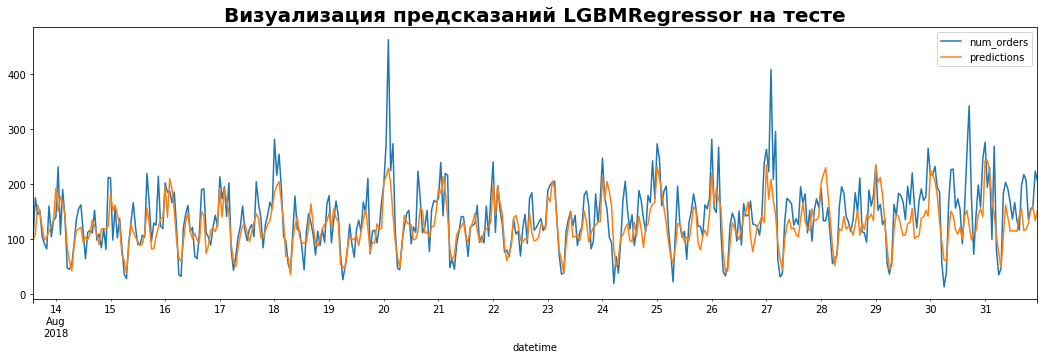

In [39]:
plot_preds_true(y_test, prediction_best_model, 'predictions', 'LGBMRegressor')

По графику видно, что модель плохо предсказвает пики, точнее она вообще их не предсказывает. График предсказания модели выглядит более стандартизированным. Моедль имеет смысл, так как ее предсказание на порядок точнее, чем предсказание константой и предсказание предыдущим значением

## Общий вывод

1. **Изучение и предобработка данных**
    - Ряд вряд-ли является стационарным, так как его среднее значение изменяться
    - Тренд идет на повышение количества заказов
    - Сезонность говорит о том, что самое большое количество заказов приходиться на конец дня, а самое маленькое на ночь
    - В остатках видны выбросы, все пики остатков приходятся на конец августа, там же заметно резкое возрастание количества заказов
    - Данные были ресемплированны по одному дню
2. **Обучение моделей**
    - Данные были разделены на выборки, было проведена проверка, что разделение не перемешала значения
    - Были рассчитаны предсказание константой и предыдущим значением
    - При помощи пайплайнов и RandomizedSearchCV была выбрана лучшая модель по метрике RMSE на кросс-валидации - это модлеь RandomForestRegressor
    - При помощи Optuna были подобранны лучшие пораметры для модели градиентного бустинга LGBMRegressor
    - Модель LGBMRegressor делает более точные предсказания и обучается быстрее чем рандомный лес
3. **Анализ моделей**
    - По итогам резкльтатов кросс-валидации была выбрана лучшая модель, ей оказалась модель LGBMRegressor
    - Ее метрика на тестовых данных сильно хуже чем на этапе кросс-валидации, но это объясняется тем, что тестовые данные как раз приходятся на конец августа, где есть большие всплески количества заказов. Возможно это связано с развитием и увеличением популярности сервиса, возможно в городе в это время проходил какой-нибудь фестиваль/конференция
    - Метрика модели на тестовых данных удовлетворяет условию задачи (RMSE <= 48)